In [51]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [52]:
# -*- coding: utf-8 -*-
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Setting pandas dataframe display options
pd.set_option('display.width', 400)
pd.set_option('max_colwidth', 400)
pd.set_option("display.max_rows", 20)

# Set pandas style
plt.style.use('seaborn')

Begin = "2007-07-13"
#yesterday = datetime.now() - timedelta(days = 1)
#End   = yesterday.strftime('%Y-%m-%d')
End = "2014-12-31"
Ano = "2016-12-30"
                           
Tickers = ['F000000FH0', 'F0000007LD', "F0GBR06T61", 'F0GBR04E6R', 'F0GBR05ZUY', 'F0GBR06T6D', 'F000000GHB', 'F0GBR04UGX']
Nomes = ['GS_SC', 'MG_OI', 'PimcoGB', 'MFS_GE', 'MFS_TR', 'PimcoHY', 'MG_conv', 'MFS_ESC']
fundos = pd.DataFrame()

# attaching FCI
Ticker = 'F0GBR04EAN'
Nome = ['FCI']
Nomes = Nome + Nomes

# Conversão de datetime
conv = time.strptime(Begin,"%Y-%m-%d") 
start_date = time.strftime("%m/%d/%Y",conv)

# URLs
FCI_url = "https://lt.morningstar.com/api/rest.svc/timeseries_price/okhysb8aoh?id=" + Ticker + "&currencyId=BAS&idtype=Morningstar&frequency=daily&startDate=" + start_date + "&outputType=CSV"

#### Downloading, formating dataframes and transforming date into datetime ####
# FCI
fundos = pd.read_csv(FCI_url, sep = ";" , index_col = 'date', parse_dates = True)
fundos = fundos.drop('Unnamed: 2', 1)

# Download
for ticker in Tickers:
    url = "https://lt.morningstar.com/api/rest.svc/timeseries_price/okhysb8aoh?id=" + str(ticker) + "&currencyId=BAS&idtype=Morningstar&frequency=daily&startDate=" + start_date + "&outputType=CSV"
    fundo = pd.read_csv(url, sep = ";" , index_col = 'date', parse_dates = True)
    fundo =  fundo.drop('Unnamed: 2', 1)
    fundos = fundos.merge(fundo, left_index = True, right_index = True, how='outer')

fundos.columns = Nomes
fundos = fundos.fillna(method='ffill')

#### Returns ####
returns = (fundos / fundos.shift(1)) - 1

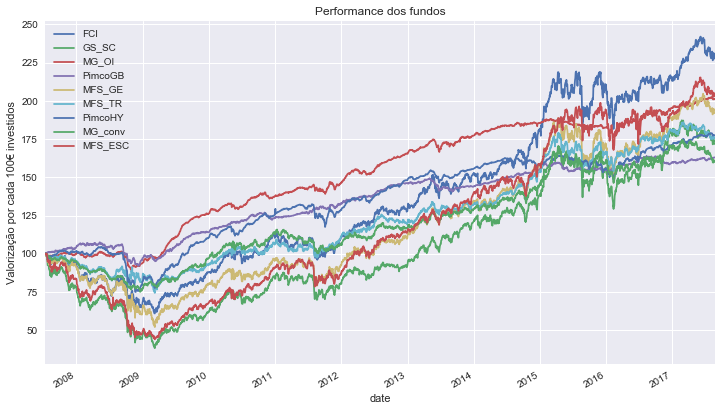

In [53]:
#### Normalization to 100 ####
fundos_norm = (fundos / fundos.iloc[0] * 100)
fundos_norm.plot(figsize = (12, 7))
plt.title('Performance dos fundos')
plt.ylabel('Valorização por cada 100€ investidos')
plt.show()

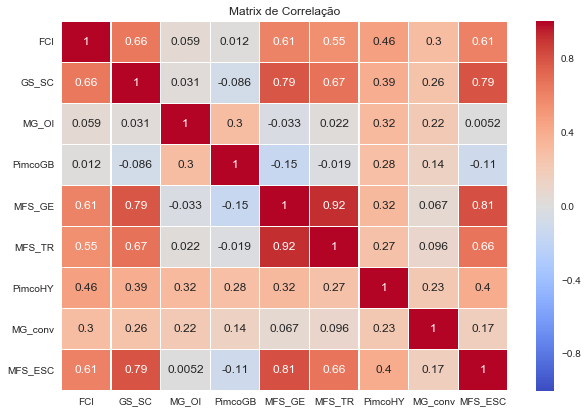

In [56]:
#### New Preturns (to include Portfolio returns) ####
Preturns = (fundos / fundos.shift(1))

#### Correlation (bonus: Seaborn heatmap)####
Pcorr_matrix = Preturns.corr()
a = -0.5

# Normal heatmap
fig, ax = plt.subplots()
fig.set_size_inches(10, 6.8) # 68%
sns.heatmap(Pcorr_matrix, annot = True, cmap = "coolwarm", linewidths=.2)
plt.title('Matrix de Correlação')
plt.show()

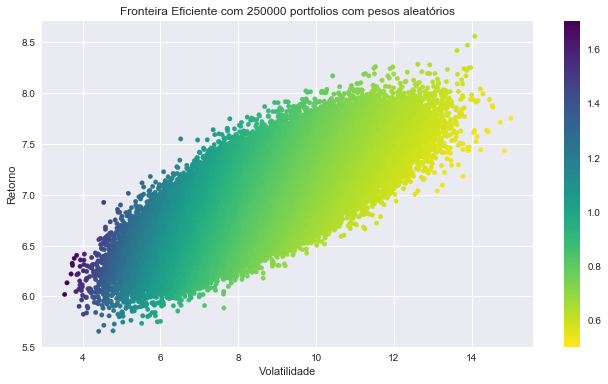

In [5]:
#### Setting seed for pseudo random number generator ###
np.random.seed(0)

#### Markowitz's Efficient Frontier ####
cov_matrix = returns.cov() * 252
corr_matrix = returns.corr()

num_assets = len(fundos.columns)
# print(num_assets)

#==============================================================================
# print("")
# print("Average returns:" + str(np.sum(weights * returns.mean()) * 252))
# print("Average variance:" + str(np.dot(weights.T, np.dot(returns.cov() * 252, weights))))
# print("Average SD:" + str(np.sqrt(np.dot(weights.T,np.dot(returns.cov() * 252, weights)))))
# 
#==============================================================================
pfolio_returns = []
pfolio_volatilities = []
pfolio_weights = []
nportfolios = 250000

for x in range (nportfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    pfolio_weights.append(weights)
    pfolio_returns.append(np.sum(weights * returns.mean()) * 252 * 100 * 1.04)
    pfolio_volatilities.append(np.sqrt(np.dot(weights.T,np.dot(returns.cov() * 252, weights))) * 100)
    
pfolio_returns = np.array(pfolio_returns)
pfolio_volatilities = np.array(pfolio_volatilities)

# Making a dataframe with the values
portfolios = pd.DataFrame({"Return": pfolio_returns,
                           "Volatility": pfolio_volatilities})

#### Adding Sharpe and weights to portfolios dataframe ####
portfolios["Sharpe"] = portfolios["Return"] / portfolios["Volatility"]
portfolios["Weights"] = pfolio_weights
Sharpe_array = np.array(portfolios['Sharpe'])

# select portfolio with highest sharpe
max_sharpe = portfolios['Sharpe'] > max(portfolios['Sharpe']) - 0.000000001
# Select MVP
MVP = portfolios['Volatility'] == min(portfolios['Volatility'])

Portfolio_max_sharpe = portfolios[max_sharpe]
a = Portfolio_max_sharpe['Volatility']
b = Portfolio_max_sharpe['Return']

# print(portfolios.head())
# print(portfolios.tail())
# Ploting on a graph
portfolios.plot(x = "Volatility", y = "Return", kind = "Scatter", figsize = (11, 6), c = Sharpe_array,  cmap = 'viridis_r' , sharex=False)
plt.ylabel("Retorno")
plt.xlabel("Volatilidade")
plt.title(str('Fronteira Eficiente com ' + str(nportfolios) + ' portfolios com pesos aleatórios'))
plt.show()

In [64]:
# Seleccionar retorno e volatilidade desejadas para filtrar os portfolios
Retorno = 6.8
Volatilidade = 5

In [65]:
#### Selecting Portfolios ####
return_target = portfolios['Return'] > Retorno # Filter portfolios by return
volatility_target = portfolios['Volatility'] < Volatilidade # Filter portfolios by volatility
# select portfolio with highest sharpe
max_sharpe = portfolios['Sharpe'] > max(portfolios['Sharpe']) - 0.000000001
# Select MVP
MVP = portfolios['Volatility'] == min(portfolios['Volatility'])

Portfolios_target = portfolios[return_target & volatility_target]
Portfolio_MVP = portfolios[MVP]

In [66]:
print("Os portfolios com retorno maior que " + str(Retorno) + " e volatilidade inferior a " + str(Volatilidade) + " são:")
Portfolios_target

Os portfolios com retorno maior que 6.8 e volatilidade inferior a 5 são:


,Return,Volatility,Sharpe,Weights
47419,6.827644,4.910897,1.390305,"[0.172756072173, 0.0457435352285, 0.334695597499, 0.229191303222, 0.0253234726373, 0.0436503375995, 0.110925551107, 0.0241457729234, 0.0135683576101]"
97911,6.924263,4.541430,1.524688,"[0.165505179226, 0.0426828619898, 0.461315149117, 0.15228063905, 0.008771998141, 0.00281336112068, 0.0702631816591, 0.0789803728024, 0.0173872568939]"
126769,6.827123,4.953629,1.378206,"[0.0848484751602, 0.00679292529116, 0.349995122475, 0.0583525508299, 0.0246955606722, 0.00615994337379, 0.247263975476, 0.107605795317, 0.114285651404]"
190161,6.855398,4.896190,1.400150,"[0.141355138576, 0.0251261951175, 0.334323787151, 0.238960284457, 0.0676616158003, 0.000700502015789, 0.119427357835, 0.0260385540987, 0.0464065649493]"
236670,6.899066,4.974365,1.386924,"[0.142181547859, 0.0655633612417, 0.433708672537, 0.147365579309, 0.000886425305674, 0.127632714212, 0.0591675333719, 0.017602699718, 0.00589146644566]"


In [67]:
len(Portfolios_target)

5

In [68]:
Nomes

['FCI',
 'GS_SC',
 'MG_OI',
 'PimcoGB',
 'MFS_GE',
 'MFS_TR',
 'PimcoHY',
 'MG_conv',
 'MFS_ESC']

#### Portfolio realista ideal

In [69]:
Portfolios_target[Portfolios_target['Sharpe'] == Portfolios_target['Sharpe'].min() ]

,Return,Volatility,Sharpe,Weights
126769,6.827123,4.953629,1.378206,"[0.0848484751602, 0.00679292529116, 0.349995122475, 0.0583525508299, 0.0246955606722, 0.00615994337379, 0.247263975476, 0.107605795317, 0.114285651404]"


In [58]:
Portfolio_max_sharpe

,Return,Volatility,Sharpe,Weights
26590,6.133477,3.597784,1.704793,"[0.0427723331035, 0.0194835233874, 0.262362139121, 0.273125183093, 0.0104189875993, 0.0614982834777, 0.25052295664, 0.0717480030856, 0.00806859049169]"


In [59]:
Portfolio_MVP

,Return,Volatility,Sharpe,Weights
36610,6.019104,3.537765,1.701386,"[0.00110095195654, 0.00626449843609, 0.234563207356, 0.284143807861, 0.0419862229125, 0.0553533945285, 0.340345003793, 0.0342430428039, 0.00199987035213]"


In [60]:
Nomes

['FCI',
 'GS_SC',
 'MG_OI',
 'PimcoGB',
 'MFS_GE',
 'MFS_TR',
 'PimcoHY',
 'MG_conv',
 'MFS_ESC']

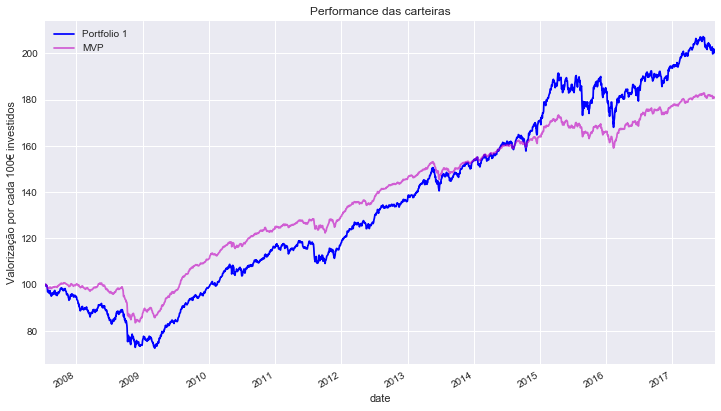

In [61]:
### weights ####
weights1 = np.array(         [0.257732842874, 0.0226644262175, 0.302350821392, 0.00521473087685, 0.0662420131071, 0.0576862759813, 0.0848807446644, 0.0733737307365, 0.12985441415]            )
weights2 = np.array(       [0.0427723331035, 0.0194835233874, 0.262362139121, 0.273125183093, 0.0104189875993, 0.0614982834777, 0.25052295664, 0.0717480030856, 0.00806859049169]              )

### Calculate Portfolio value with linear algebra ####
fundos["Portfolio1"] = np.dot(fundos_norm, weights1) # weights1 * quotes
fundos["Portfolio2"] = np.dot(fundos_norm, weights2) # weights1 * quotes

fundos["Portfolio1"].plot(figsize = (12, 7), title = "Portfolio", c = 'b', alpha = 1, label = 'Portfolio 1 ')
fundos["Portfolio2"].plot(figsize = (12, 7), title = "Portfolio", c = 'm', alpha = 0.6, label = 'MVP')

plt.legend(loc='upper left')
plt.title('Performance das carteiras')
plt.ylabel('Valorização por cada 100€ investidos')
plt.show()

In [62]:
#### New Preturns (to include Portfolio returns) ####
Preturns = (fundos / fundos.shift(1))

#### Annualized return of portfolio 1 (in sample) ####
print('Dados para o portfolio 1 (in sample):')
a = fundos["Portfolio1"].loc[Begin]
b = fundos["Portfolio1"].loc['2017-07-25']
z = fundos["Portfolio1"].loc[Ano]

time_delta = pd.to_datetime(End) - pd.to_datetime(Begin)
time_delta = time_delta.days / 365

Annualized_Return = (((b / a) ** (1 / time_delta)) - 1) * 100
print("")
print("O retorno anualizado é: "
      + str(round(Annualized_Return, 2)) + "%")

#### Standard Deviation as Risk 1 (in sample)####
Annualized_SD = Preturns["Portfolio1"].std() * 252 ** 0.5 * 100
print("O desvio padrão anualizado é: "
      + str(round(Annualized_SD, 2)) + "%")

print('\nDados para o portfolio 1 (out of sample):')
c = fundos["Portfolio1"].iloc[-1]

#### YTD Return 1 (out of sample) ####
d = ((c / z) - 1) * 100

#### Annualized return of portfolio 1 (out of sample) ####
time_delta2 = fundos.index[-1] - pd.to_datetime(End)
time_delta2 = time_delta2.days / 365
Annualized_Return = (((c / b) ** (1 / time_delta2)) - 1) * 100
print("\nO retorno anualizado é: "
      + str(round(Annualized_Return, 2)) + "%")

#### Standard Deviation as Risk (out of sample) ####
Annualized_SD = Preturns["Portfolio2"].std() * 252 ** 0.5 * 100
print("O desvio padrão anualizado é (em construção) : "
      + str(round(Annualized_SD, 2)) + "%")

print("O retorno desde o início do ano é: "
      + str(round(d, 2)) + "%")

######################################################################
##### Annualized return of portfolio (in sample) ####
print('\nDados para o portfolio 2 (in sample):')
a = fundos["Portfolio2"].loc[Begin]
b = fundos["Portfolio2"].loc['2017-07-25']

time_delta = pd.to_datetime(End) - pd.to_datetime(Begin)
time_delta = time_delta.days / 365

Annualized_Return = (((b / a) ** (1 / time_delta)) - 1) * 100
print("")
print("O retorno anualizado é: "
      + str(round(Annualized_Return, 2)) + "%")

#### Standard Deviation as Risk (in sample) ####
Annualized_SD = Preturns["Portfolio2"].std() * 252 ** 0.5 * 100
print("O desvio padrão anualizado é (em construção) : "
      + str(round(Annualized_SD, 2)) + "%")

print('\nDados para o portfolio 2 (out of sample):')
c = fundos["Portfolio2"].iloc[-1]
b = fundos["Portfolio2"].loc["2017-07-25"]
z = fundos["Portfolio2"].loc[Ano]

#### Annualized return of portfolio 2 (out of sample) ####
Annualized_Return = (((c / b) ** (1 / time_delta2)) - 1) * 100
print("")
print("O retorno anualizado é: "
      + str(round(Annualized_Return, 2)) + "%")

#### Standard Deviation as Risk 2 (out of sample) ####
Annualized_SD = Preturns["Portfolio2"].std() * 252 ** 0.5 * 100
print("O desvio padrão anualizado é: "
      + str(round(Annualized_SD, 2)) + "%")

#### YTD Return 2 (out of sample) ####
d = ((c / z) - 1) * 100

print("O retorno desde o início do ano é: "
      + str(round(d, 2)) + "%")

Dados para o portfolio 1 (in sample):

O retorno anualizado é: 9.93%
O desvio padrão anualizado é: 7.31%

Dados para o portfolio 1 (out of sample):

O retorno anualizado é: -0.42%
O desvio padrão anualizado é (em construção) : 3.47%
O retorno desde o início do ano é: 3.7%

Dados para o portfolio 2 (in sample):

O retorno anualizado é: 8.32%
O desvio padrão anualizado é (em construção) : 3.47%

Dados para o portfolio 2 (out of sample):

O retorno anualizado é: -0.19%
O desvio padrão anualizado é: 3.47%
O retorno desde o início do ano é: 2.1%


In [63]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code